# Detección de tipo de células blancas

### Introducción

Un problema importante en el diagnóstico de la sangre es la clasificación de diferentes tipos de células sanguíneas.
En este cuaderno, intentaremos entrenar a un clasificador para predecir el tipo de célula sanguínea a la que se le
dará una imagen teñida.

### Datos

Tenemos 352 imágenes de glóbulos blancos teñidos junto con etiquetas de qué tipo de célula sanguínea son. A continuación se muestra un ejemplo de cada uno de los tipos de células sanguíneas en nuestro conjunto de datos.

#### Eosinófilo
![Eosinófilo](muestras/eosinofilo.jpg)

#### Linfocito
![Linfocito](muestras/linfocito.jpg)

#### Monocito
![Monocito](muestras/monocito.jpg)

#### Neutrófilo
![Neutrófilo](muestras/neutrofilo.jpg)

### Metodología

Utilizamos el modelo preentrenado ofrecido en keras VGG16 y luego se usa al final una softmax para la clasificación.

### Resultados

Obtuvimos 79% de presición en una validación de 79 elementos

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import keras
from keras.utils import to_categorical
import os
from keras.preprocessing.image import ImageDataGenerator, load_img

/Users/fran/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [8]:
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [9]:
train_dir = './base-de-datos/entrenamiento'
validation_dir = './base-de-datos/validacion'

nTrain = 2497 + 2483 + 2478 + 2499
nVal = 2569

In [10]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

train_features = np.zeros(shape=(nTrain, 7, 7, 512))
train_labels = np.zeros(shape=(nTrain,4))

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True)

Found 9957 images belonging to 4 classes.


In [12]:
validation_features = np.zeros(shape=(nVal, 7, 7, 512))
validation_labels = np.zeros(shape=(nVal,4))

validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

i = 0
for inputs_batch, labels_batch in validation_generator:
    features_batch = vgg_conv.predict(inputs_batch)
    validation_features[i * batch_size : (i + 1) * batch_size] = features_batch
    validation_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nVal:
        break

validation_features = np.reshape(validation_features, (nVal, 7 * 7 * 512))

Found 71 images belonging to 4 classes.


In [14]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=7 * 7 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=20,
                    batch_size=batch_size,
                    validation_data=(validation_features,validation_labels))

Train on 9957 samples, validate on 71 samples
Epoch 1/20
9957/9957 [==============================] - 104s 10ms/step - loss: 1.2759 - acc: 0.4486 - val_loss: 1.1400 - val_acc: 0.4648
Epoch 2/20
9957/9957 [==============================] - 103s 10ms/step - loss: 0.8549 - acc: 0.6534 - val_loss: 0.7825 - val_acc: 0.6620
Epoch 3/20
9957/9957 [==============================] - 97s 10ms/step - loss: 0.6499 - acc: 0.7496 - val_loss: 0.7668 - val_acc: 0.6620
Epoch 4/20
9957/9957 [==============================] - 95s 10ms/step - loss: 0.5204 - acc: 0.7999 - val_loss: 0.7800 - val_acc: 0.6901
Epoch 5/20
9957/9957 [==============================] - 97s 10ms/step - loss: 0.4387 - acc: 0.8290 - val_loss: 0.6342 - val_acc: 0.7606
Epoch 6/20
9957/9957 [==============================] - 97s 10ms/step - loss: 0.3785 - acc: 0.8567 - val_loss: 0.6765 - val_acc: 0.7606
Epoch 7/20
9957/9957 [==============================] - 95s 10ms/step - loss: 0.3253 - acc: 0.8773 - val_loss: 0.8234 - val_acc: 0.7324


In [16]:
fnames = validation_generator.filenames

ground_truth = validation_generator.classes

label2index = validation_generator.class_indices

# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())

In [17]:
predictions = model.predict_classes(validation_features)
prob = model.predict(validation_features)

In [18]:
errors = np.where(predictions != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),nVal))

No of errors = 15/71


Original label:EOSINOFILO, Prediction :NEUTROFILO, confidence : 0.883


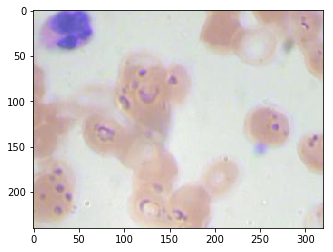

Original label:EOSINOFILO, Prediction :LINFOCITO, confidence : 0.987


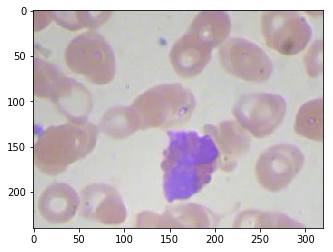

Original label:EOSINOFILO, Prediction :NEUTROFILO, confidence : 0.631


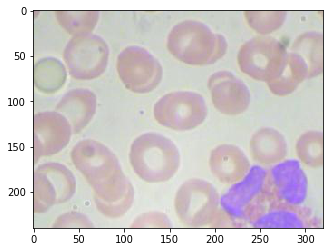

Original label:EOSINOFILO, Prediction :NEUTROFILO, confidence : 0.794


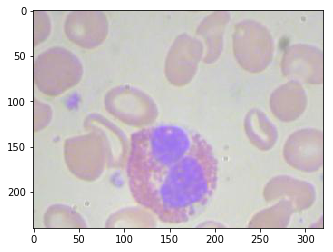

Original label:EOSINOFILO, Prediction :NEUTROFILO, confidence : 0.883


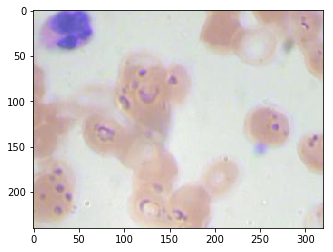

Original label:EOSINOFILO, Prediction :NEUTROFILO, confidence : 0.515


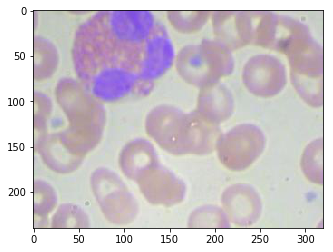

Original label:EOSINOFILO, Prediction :NEUTROFILO, confidence : 0.987


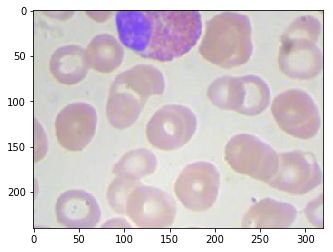

Original label:MONOCITO, Prediction :NEUTROFILO, confidence : 0.512


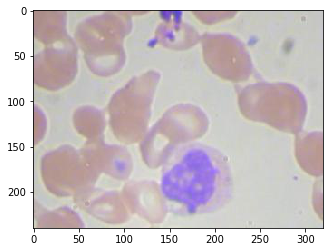

Original label:MONOCITO, Prediction :NEUTROFILO, confidence : 0.593


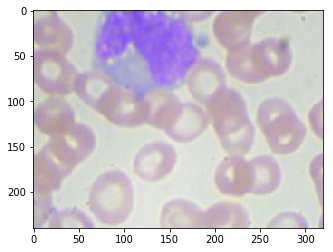

Original label:MONOCITO, Prediction :NEUTROFILO, confidence : 0.581


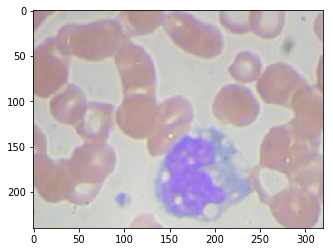

Original label:MONOCITO, Prediction :NEUTROFILO, confidence : 0.584


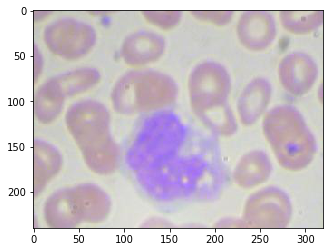

Original label:NEUTROFILO, Prediction :EOSINOFILO, confidence : 0.449


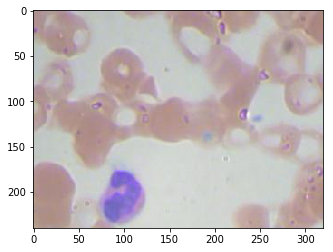

Original label:NEUTROFILO, Prediction :LINFOCITO, confidence : 0.433


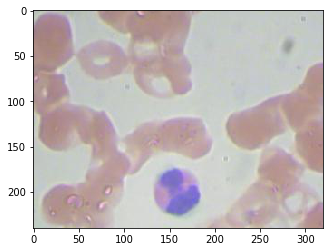

Original label:NEUTROFILO, Prediction :EOSINOFILO, confidence : 0.450


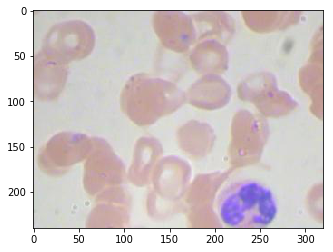

Original label:NEUTROFILO, Prediction :EOSINOFILO, confidence : 0.504


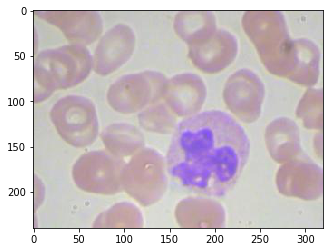

In [19]:
for i in range(len(errors)):
    pred_class = np.argmax(prob[errors[i]])
    pred_label = idx2label[pred_class]
    
    print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        prob[errors[i]][pred_class]))
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.imshow(original)
    plt.show()